In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import pickle
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
os.listdir('../input/lish-moa')

['sample_submission.csv',
 'train_drug.csv',
 'train_targets_scored.csv',
 'train_targets_nonscored.csv',
 'train_features.csv',
 'test_features.csv']

In [3]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [4]:
train_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371


In [5]:
train_targets_scored.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_targets_nonscored.head(2)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.151,-0.775
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.381,-0.730


In [8]:
sample_submission.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [9]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASSED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## preprocess data

In [10]:
def drop_ctl_vehicle(train_features, test_features):
    
    train_features = train_features[train_features['cp_type'] != 'ctl_vehicle']
    test_features = test_features[test_features['cp_type'] != 'ctl_vehicle']
    target = train_targets_scored.iloc[train_features.index]
    train_features.reset_index(drop=True, inplace=True)
    test_features.reset_index(drop=True, inplace=True)
    
    return train_features, test_features, target

# train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
# test_features

In [11]:
def rank_gauss(train_features, test_features):
    
    train_features_ = train_features.copy()
    test_features_ = test_features.copy()
    
    GENES = [col for col in train_features_.columns if col.startswith('g-')]
    CELLS = [col for col in train_features_.columns if col.startswith('c-')]
    
    for col in (GENES + CELLS):

        transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
        vec_len = len(train_features_[col].values)
        vec_len_test = len(test_features_[col].values)
        raw_vec = train_features_[col].values.reshape(vec_len, 1)
        transformer.fit(raw_vec)

        train_features_[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
        test_features_[col] = transformer.transform(test_features_[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
        
    return train_features_, test_features_

# train_features1, test_features1 = rank_gauss(train_features, test_features)
# train_features1

In [12]:
def get_stats(train_features, test_features):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    for df in [train_features, test_features]:
#         df['g_sum'] = df[GENES].sum(axis = 1)
        df['g_mean'] = df[GENES].mean(axis = 1)
        df['g_std'] = df[GENES].std(axis = 1)
        df['g_kurt'] = df[GENES].kurtosis(axis = 1)
        df['g_skew'] = df[GENES].skew(axis = 1)
#         df['g_max'] = df[GENES].max(axis=1)
#         df['g_min'] = df[GENES].max(axis=1)
#         df['c_sum'] = df[CELLS].sum(axis=1)
        df['c_mean'] = df[CELLS].mean(axis = 1)
        df['c_std'] = df[CELLS].std(axis = 1)
        df['c_kurt'] = df[CELLS].kurtosis(axis = 1)
        df['c_skew'] = df[CELLS].skew(axis = 1)
#         df['c_max'] = df[CELLS].max(axis=1)
#         df['c_min'] = df[CELLS].min(axis=1)
#         df['gc_sum'] = df[GENES + CELLS].sum(axis = 1)
        df['gc_mean'] = df[GENES + CELLS].mean(axis = 1)
        df['gc_std'] = df[GENES + CELLS].std(axis = 1)
        df['gc_kurt'] = df[GENES + CELLS].kurtosis(axis = 1)
        df['gc_skew'] = df[GENES + CELLS].skew(axis = 1)
        
    return train_features, test_features

# train_features, test_features = get_stats(train_features, test_features)
# test_features

In [13]:
def get_pca(train_features, test_features, n_gs, n_cs):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    pca_gs = PCA(n_components = n_gs)
    pca_cs = PCA(n_components = n_cs)
    
    train_pca_gs = pca_gs.fit_transform(train_features[GENES])
    train_pca_cs = pca_cs.fit_transform(train_features[CELLS])
    test_pca_gs = pca_gs.transform(test_features[GENES])
    test_pca_cs = pca_cs.transform(test_features[CELLS])
    
    train_pca_gs = pd.DataFrame(train_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    train_pca_cs = pd.DataFrame(train_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    test_pca_gs = pd.DataFrame(test_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    test_pca_cs = pd.DataFrame(test_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    
    train_features = pd.concat([train_features, train_pca_gs, train_pca_cs], axis=1)
    test_features = pd.concat([test_features, test_pca_gs, test_pca_cs], axis=1)
    
    return train_features, test_features

# train_features, test_features = get_pca(train_features, test_features, n_gs=50, n_cs=15)
# test_features

In [14]:
def var_thresh(threshold, train_features, test_features):

    cols_numeric = [f for f in train_features.columns if f not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]
    mask = (train_features[cols_numeric].var() >= 0.8).values
    train_features_ = train_features[cols_numeric].loc[:, mask]
    test_features_ = test_features[cols_numeric].loc[:, mask]
    train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1).reset_index(drop=True)
    test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1).reset_index(drop=True)

    return train_features, test_features

# train_features, test_features = var_thresh_2(threshold=0.2, train_features=train_features, test_features=test_features)
# test_features

In [15]:
def get_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 0):
    
    GENES = [col for col in train.columns if col.startswith('g-')]
    CELLS = [col for col in train.columns if col.startswith('c-')]
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        
        return train, test
    
    train, test = create_cluster(train, test, GENES, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, CELLS, kind = 'c', n_clusters = n_clusters_c)
    
    return train, test

# train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)

In [16]:
def scaling(train_features, test_features):
    
    scaler = RobustScaler()
    train_features_ = train_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1)
    columns_ = train_features_.columns
    train_features_numerical = scaler.fit_transform(train_features_)
    test_features_numerical = scaler.transform(test_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1))
    train_features_ = pd.DataFrame(train_features_numerical)
    test_features_ = pd.DataFrame(test_features_numerical)
    train_features_ = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1)
    test_features_ = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1)
    
    return train_features_, test_features_

# train_features, test_features = scaling2(train_features, test_features)
# test_features

In [17]:
def make_folds(train, num_starts, num_splits):
    
    train_ = train.copy()
    folds = []

    # LOAD FILES
    train_feats = pd.read_csv('../input/lish-moa/train_features.csv')
    scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
    drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
    scored = scored.loc[train_feats['cp_type'] == 'trt_cp', :]
    drug = drug.loc[train_feats['cp_type'] == 'trt_cp', :]
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left') 

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[(vc <= 6) | (vc == 12) | (vc == 18)].index.sort_values()
    vc2 = vc.loc[(vc > 6) & (vc != 12) & (vc != 18)].index.sort_values()

    for seed in range(num_starts):

        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}; dct2 = {}
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop = True)
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        scored['fold'] = scored.drug_id.map(dct1)
        scored.loc[scored.fold.isna(),'fold'] =\
            scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
        scored.fold = scored.fold.astype('int8')
        folds.append(scored.fold.values)

        del scored['fold']
        
        for i in range(len(folds)):
            train_[f'seed{i}'] = folds[i]

    return train_

In [18]:
def preprocessor(train_features, test_features):
    
    print('preprocess start')
    
#     # drop_ctl_vehicle
#     train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
    
    # rank_gauss
    train_features, test_features = rank_gauss(train_features, test_features)
    print('rank_gauss: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # stats
    train_features, test_features = get_stats(train_features, test_features)
    print('get_stats: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # pca
    train_features, test_features = get_pca(train_features, test_features, n_gs=600, n_cs=50) 
    print('get_pca: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # var_thresh
    train_features, test_features = var_thresh(threshold=0.8, train_features=train_features, test_features=test_features)
    print('var_thresh: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
#     # clustering
#     train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)
#     print('clustering: done')
#     print('train_features.shape', train_features.shape)
#     print('test_features.shape', test_features.shape)
    
#     # Scaling
#     train_features, test_features = scaling(train_features, test_features)
#     print('scaling: done')
    
    # data merge
    train = train_features.merge(train_targets_scored, on='sig_id').merge(train_targets_nonscored, on ='sig_id')
    train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
    test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

    target = train[train_targets_scored.columns]
    target_nonscored = train[train_targets_nonscored.columns]
    
    train = train.drop('cp_type', axis=1)
    test = test.drop('cp_type', axis=1)
    
    return train, target, test, target_nonscored  

train, target, test, target_nonscored = preprocessor(train_features, test_features)

preprocess start
rank_gauss: done
train_features.shape (23814, 876)
test_features.shape (3982, 876)
get_stats: done
train_features.shape (23814, 888)
test_features.shape (3982, 888)
get_pca: done
train_features.shape (23814, 1538)
test_features.shape (3982, 1538)
var_thresh: done
train_features.shape (23814, 1044)
test_features.shape (3982, 1044)


In [19]:
folds = make_folds(train, num_starts=5, num_splits=5)

In [20]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
target_nonscored_cols = target_nonscored.drop('sig_id', axis=1).columns.values.tolist()
feature_cols = [c for c in pd.get_dummies(train, columns=['cp_time', 'cp_dose']).columns if (c not in target_cols) & (c not in target_nonscored_cols)]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id']]
all_target_cols = target_cols + target_nonscored_cols

num_features = len(feature_cols)
num_targets = len(target_cols)
num_targets_nonscored = len(target_nonscored_cols)
num_all_targets = len(all_target_cols)

print(f'num_features: {num_features}')
print(f'num_targets: {num_targets}')
print(f'num_targets_nonscored: {num_targets_nonscored}')
print(f'num_all_targets: {num_all_targets}')

num_features: 1045
num_targets: 206
num_targets_nonscored: 402
num_all_targets: 608


### shape check

In [21]:
print(f'train.shape: {train.shape}')
print(f'folds.shape: {folds.shape}')
print(f'test.shape: {test.shape}')
print(f'target.shape: {target.shape}')
print(f'target_nonscored.shape: {target_nonscored.shape}')
print(f'sample_submission.shape: {sample_submission.shape}')

train.shape: (21948, 1651)
folds.shape: (21948, 1656)
test.shape: (3624, 1043)
target.shape: (21948, 207)
target_nonscored.shape: (21948, 403)
sample_submission.shape: (3982, 207)


In [22]:
all_data = {
    'train': train, 
    'folds': folds, 
    'test': test, 
    'target': target, 
    'target_nonscored': target_nonscored, 
    'sample_submission': sample_submission
}

In [23]:
with open('all_data_Simple_Deep.pickle', 'wb') as f:
    pickle.dump(all_data, f)

## Dataset Classes

In [24]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float), 
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

### HyperParameters

In [25]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 24
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NFOLDS = 5

smoothing = 0.001
p_min = smoothing
p_max = 1 - smoothing

WEIGHT_DECAY = {'ALL_TARGETS': 1e-5, 'SCORED_ONLY': 3e-6}
MAX_LR = {'ALL_TARGETS': 1e-2, 'SCORED_ONLY': 3e-3}
DIV_FACTOR = {'ALL_TARGETS': 1e3, 'SCORED_ONLY': 1e2}
PCT_START = 0.1

### Model

In [26]:
class Model_Simple_Deep(nn.Module):
    
    def __init__(self, num_features, num_targets):
        
        super(Model_Simple_Deep, self).__init__()
        self.hidden_size = [1500, 1250, 1000, 750]
        self.dropout_value = [0.5, 0.35, 0.3, 0.25]

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, self.hidden_size[0])
        
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size[0])
        self.dropout2 = nn.Dropout(self.dropout_value[0])
        self.dense2 = nn.Linear(self.hidden_size[0], self.hidden_size[1])

        self.batch_norm3 = nn.BatchNorm1d(self.hidden_size[1])
        self.dropout3 = nn.Dropout(self.dropout_value[1])
        self.dense3 = nn.Linear(self.hidden_size[1], self.hidden_size[2])

        self.batch_norm4 = nn.BatchNorm1d(self.hidden_size[2])
        self.dropout4 = nn.Dropout(self.dropout_value[2])
        self.dense4 = nn.Linear(self.hidden_size[2], self.hidden_size[3])

        self.batch_norm5 = nn.BatchNorm1d(self.hidden_size[3])
        self.dropout5 = nn.Dropout(self.dropout_value[3])
        self.dense5 = nn.utils.weight_norm(nn.Linear(self.hidden_size[3], num_targets))
    
    def forward(self, x):
        
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))

        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))

        x = self.batch_norm5(x)
        x = self.dropout5(x)
        x = self.dense5(x)
        return x
    
class LabelSmoothingLoss(nn.Module):
    
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))    

In [27]:
class FineTuneScheduler:
    def __init__(self, epochs):
        self.epochs = epochs
        self.epochs_per_step = 0
        self.frozen_layers = []
        
    def copy_without_top(self, model, num_features, num_targets, num_targets_new):
        self.frozen_layers = []
        
        model_new = Model_Simple_Deep(num_features, num_targets)
        model_new.load_state_dict(model.state_dict())
        
        # Freeze all weights
        for name, param in model_new.named_parameters():
            layer_index = name.split('.')[0][-1]
            
            if layer_index == 5:
                continue
                
            param.requires_grad = False
            
            # Save frozen layer names
            if layer_index not in self.frozen_layers:
                self.frozen_layers.append(layer_index)
                
        self.epochs_per_step = self.epochs // len(self.frozen_layers)
        
        # Replace the top layers with another ones
        model_new.batch_norm5 = nn.BatchNorm1d(model_new.hidden_size[3])
        model_new.dropout5 = nn.Dropout(model_new.dropout_value[3])
        model_new.dense5 = nn.utils.weight_norm(nn.Linear(model_new.hidden_size[-1], num_targets_new))
        model_new.to(DEVICE)
        return model_new
    
    def step(self, epoch, model):
        if len(self.frozen_layers) == 0:
            return 
        
        if epoch % self.epochs_per_step == 0:
            last_frozen_index = self.frozen_layers[-1]
            
            # Unfreeze parameters of the last frozen layer
            for name, param in model.named_parameters():
                layer_index = name.split('.')[0][-1]
                
                if layer_index == last_frozen_index:
                    param.requires_grad = True
                    
            del self.frozen_layers[-1]  # Remove the last layer as unfrozen

### training function

In [28]:
def train_fn(model, optimizer, scheduler, loss_tr, loss_fn, dataloader, device):
    rejected = 0
    model.train()
    final_loss = 0
    final_metric = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        if len(inputs) > 1:
            outputs = model(inputs)
            loss = loss_tr(outputs, targets)
            metric = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            final_loss += loss.item()
            final_metric += metric.item()
        
        else:
            print('rejected')
            rejected += len(inputs)
            
        
    final_loss /= (len(dataloader) - rejected)
    final_metric /= (len(dataloader) - rejected)
    
    return final_loss, final_metric

In [29]:
def valid_fn(model, loss_tr, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    final_metric = 0
    valid_preds = []
    
    for data in dataloader:
        
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_tr(outputs, targets)
        metric = loss_fn(outputs, targets)
        final_loss += loss.item()
        final_metric += metric.item()
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)
        valid_preds.append(outputs.numpy())
        
    final_loss /= len(dataloader)
    final_metric /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
        
    return final_loss, final_metric, valid_preds

In [30]:
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)    
        preds.append(outputs.numpy())
        
    preds = np.concatenate(preds)
        
    return preds

### loss_function

In [31]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets, n_classes, smoothing=0.0):
        assert 0 <= smoothing <= 1
        with torch.no_grad():
            targets = targets * (1 - smoothing) + torch.ones_like(targets).to(DEVICE) * smoothing / n_classes
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss()._smooth(targets, inputs.shape[1], self.smoothing)

        if self.weight is not None:
            inputs = inputs * self.weight.unsqueeze(0)

        loss = F.binary_cross_entropy_with_logits(inputs, targets)

        return loss

In [32]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets
    
    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

### Single fold training

In [33]:
def run_training(fold, seed, EPOCHS, LEARNING_RATE):
    
    print(f'==========FOLD{fold+1}==========')
    
    
    seed_everything(seed)
    
    train_losses = list()
    valid_losses = list()
    CV = list()
    
    train = pd.get_dummies(folds, columns=['cp_time', 'cp_dose'])
    test_ = pd.get_dummies(test, columns=['cp_time', 'cp_dose'])
    
    trn_idx = train[train[f'seed{seed}'] != fold].index
    val_idx = train[train[f'seed{seed}'] == fold].index
    
    train_df = train[train[f'seed{seed}'] != fold].reset_index()
    valid_df = train[train[f'seed{seed}'] == fold].reset_index()
    
    def train_model(model, tag_name, target_cols_now, fine_tune_scheduler=None):
        
        print(f'=={tag_name}==')
        
        train_losses = list()
        valid_losses = list()
        
        x_train, y_train  = train_df[feature_cols].values, train_df[target_cols_now].values
        x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols_now].values
        
        train_dataset = MoADataset(x_train, y_train)
        valid_dataset = MoADataset(x_valid, y_valid)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY[tag_name])
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                  steps_per_epoch=len(trainloader),
                                                  pct_start=PCT_START,
                                                  div_factor=DIV_FACTOR[tag_name], 
                                                  max_lr=MAX_LR[tag_name],
                                                  epochs=EPOCHS)
        
        loss_fn = nn.BCEWithLogitsLoss()
        loss_tr = SmoothBCEwLogits(smoothing=smoothing)

        oof = np.zeros((len(train), len(target_cols_now)))
        best_loss = np.inf

        for epoch in range(EPOCHS):
        
            if fine_tune_scheduler is not None:
                fine_tune_scheduler.step(epoch, model)
        
            print(f'-----EPOCH{epoch+1}-----')

            train_loss, train_metric = train_fn(model, optimizer, scheduler, loss_tr, loss_fn, trainloader, DEVICE)
            print(f'train_loss: {train_loss:.5f}, train_metric: {train_metric:.5f}')
            train_losses.append(train_loss)
            valid_loss, valid_metric, valid_preds = valid_fn(model, loss_tr, loss_fn, validloader, DEVICE)
            print(f'valid_loss: {valid_loss:.5f}, valid_metric: {valid_metric:.5f}')
            valid_losses.append(valid_loss)

            if valid_loss < best_loss:

                best_loss = valid_loss
                oof[val_idx] = valid_preds
                torch.save(model.state_dict(), f'Simple_Deep_FOLD{fold+1}_SEED{seed}.pth')

        plt.plot(train_losses, label='train_losses')
        plt.plot(valid_losses, label='valid_losses')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        if tag_name == 'ALL_TARGETS':
            plt.ylim([6e-3, 1.5e-2])
        else:
            plt.ylim([1e-2, 2e-2])
        plt.title(f'fold{fold+1} losses')
        plt.show()

        return oof
    
    fine_tune_scheduler = FineTuneScheduler(EPOCHS)
    
    pretrained_model = Model_Simple_Deep(num_features, num_all_targets)
    pretrained_model.to(DEVICE)
    
    # Train on scored + nonscored targets
    train_model(pretrained_model, 'ALL_TARGETS', all_target_cols)
    
    # Load the pretrained model with the best loss
    pretrained_model = Model_Simple_Deep(num_features, num_all_targets)
    pretrained_model.load_state_dict(torch.load(f'Simple_Deep_FOLD{fold+1}_SEED{seed}.pth'))
    pretrained_model.to(DEVICE)
    
    # Copy model without the top layer)
    final_model = fine_tune_scheduler.copy_without_top(pretrained_model, num_features, num_all_targets, num_targets)
    
    # Fine-ture the model on scored targets only
    oof = train_model(final_model, 'SCORED_ONLY', target_cols, fine_tune_scheduler)
    
    #-----------------------PREDICTION-------------------------
                
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load the fine tuned model with the best loss
    model = Model_Simple_Deep(num_features, num_targets)
    model.load_state_dict(torch.load(f'Simple_Deep_FOLD{fold+1}_SEED{seed}.pth'))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [34]:
def run_k_fold(NFOLD, seed, EPOCH, LEARNING_RATE):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed, EPOCH, LEARNING_RATE)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

device used: cuda
 
SEED : 0

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50840, train_metric: 0.50797
valid_loss: 0.02782, valid_metric: 0.02572
-----EPOCH2-----
train_loss: 0.01562, train_metric: 0.01279
valid_loss: 0.01371, valid_metric: 0.01062
-----EPOCH3-----
train_loss: 0.01345, train_metric: 0.01023
valid_loss: 0.01360, valid_metric: 0.01012
-----EPOCH4-----
train_loss: 0.01288, train_metric: 0.00952
valid_loss: 0.01303, valid_metric: 0.00975
-----EPOCH5-----
train_loss: 0.01283, train_metric: 0.00952
valid_loss: 0.01469, valid_metric: 0.01125
-----EPOCH6-----
train_loss: 0.01281, train_metric: 0.00949
valid_loss: 0.01408, valid_metric: 0.01082
-----EPOCH7-----
train_loss: 0.01275, train_metric: 0.00947
valid_loss: 0.01497, valid_metric: 0.01148
-----EPOCH8-----
train_loss: 0.01280, train_metric: 0.00954
valid_loss: 0.01304, valid_metric: 0.00977
-----EPOCH9-----
train_loss: 0.01272, train_metric: 0.00946
valid_loss: 0.01302, valid_metric: 0.00980
-

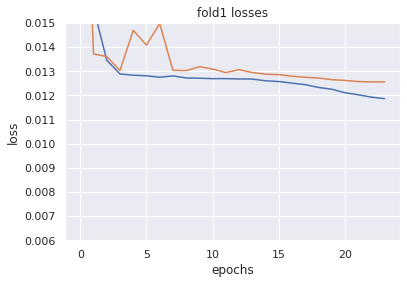

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65389, train_metric: 0.65382
valid_loss: 0.30691, valid_metric: 0.30638
-----EPOCH2-----
train_loss: 0.06741, train_metric: 0.06563
valid_loss: 0.02284, valid_metric: 0.02038
-----EPOCH3-----
train_loss: 0.02109, train_metric: 0.01838
valid_loss: 0.02051, valid_metric: 0.01764
-----EPOCH4-----
train_loss: 0.01991, train_metric: 0.01693
valid_loss: 0.02034, valid_metric: 0.01731
-----EPOCH5-----
train_loss: 0.02078, train_metric: 0.01763
valid_loss: 0.02054, valid_metric: 0.01732
-----EPOCH6-----
train_loss: 0.01958, train_metric: 0.01638
valid_loss: 0.02048, valid_metric: 0.01711
-----EPOCH7-----
train_loss: 0.01947, train_metric: 0.01625
valid_loss: 0.02042, valid_metric: 0.01713
-----EPOCH8-----
train_loss: 0.01934, train_metric: 0.01611
valid_loss: 0.02034, valid_metric: 0.01710
-----EPOCH9-----
train_loss: 0.01971, train_metric: 0.01647
valid_loss: 0.02032, valid_metric: 0.01703
-----EPOCH10-----
train_loss: 0.01935, train_metric: 0.01

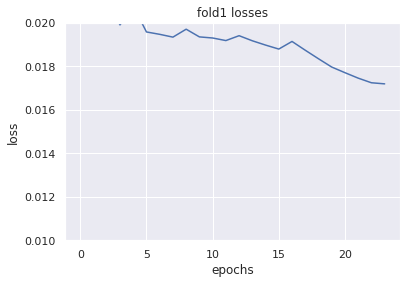

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51017, train_metric: 0.50974
valid_loss: 0.02691, valid_metric: 0.02480
-----EPOCH2-----
train_loss: 0.01605, train_metric: 0.01320
valid_loss: 0.01373, valid_metric: 0.01054
-----EPOCH3-----
train_loss: 0.01349, train_metric: 0.01021
valid_loss: 0.01327, valid_metric: 0.00990
-----EPOCH4-----
train_loss: 0.01324, train_metric: 0.00991
valid_loss: 0.01349, valid_metric: 0.00994
-----EPOCH5-----
train_loss: 0.01314, train_metric: 0.00969
valid_loss: 0.01302, valid_metric: 0.00970
-----EPOCH6-----
train_loss: 0.01269, train_metric: 0.00936
valid_loss: 0.01325, valid_metric: 0.00999
-----EPOCH7-----
train_loss: 0.01271, train_metric: 0.00942
valid_loss: 0.01313, valid_metric: 0.00982
-----EPOCH8-----
train_loss: 0.01273, train_metric: 0.00947
valid_loss: 0.01301, valid_metric: 0.00976
-----EPOCH9-----
train_loss: 0.01272, train_metric: 0.00946
valid_loss: 0.01305, valid_metric: 0.00981
-----EPOCH10-----
train_loss: 0

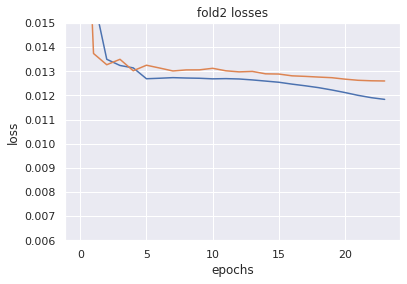

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65569, train_metric: 0.65562
valid_loss: 0.31088, valid_metric: 0.31036
-----EPOCH2-----
train_loss: 0.06805, train_metric: 0.06628
valid_loss: 0.02320, valid_metric: 0.02074
-----EPOCH3-----
train_loss: 0.02087, train_metric: 0.01815
valid_loss: 0.02116, valid_metric: 0.01827
-----EPOCH4-----
train_loss: 0.01971, train_metric: 0.01672
valid_loss: 0.02091, valid_metric: 0.01787
-----EPOCH5-----
train_loss: 0.02532, train_metric: 0.02218
valid_loss: 0.02103, valid_metric: 0.01777
-----EPOCH6-----
train_loss: 0.01941, train_metric: 0.01620
valid_loss: 0.02089, valid_metric: 0.01765
-----EPOCH7-----
train_loss: 0.01924, train_metric: 0.01601
valid_loss: 0.02098, valid_metric: 0.01766
-----EPOCH8-----
train_loss: 0.01916, train_metric: 0.01590
valid_loss: 0.02097, valid_metric: 0.01771
-----EPOCH9-----
train_loss: 0.01943, train_metric: 0.01618
valid_loss: 0.02099, valid_metric: 0.01771
-----EPOCH10-----
train_loss: 0.01918, train_metric: 0.01

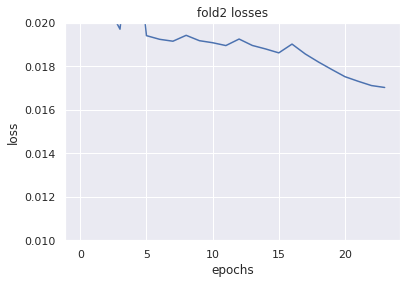

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50929, train_metric: 0.50886
valid_loss: 0.04440, valid_metric: 0.04240
-----EPOCH2-----
train_loss: 0.01610, train_metric: 0.01326
valid_loss: 0.01326, valid_metric: 0.01019
-----EPOCH3-----
train_loss: 0.01340, train_metric: 0.01019
valid_loss: 0.01421, valid_metric: 0.01084
-----EPOCH4-----
train_loss: 0.01324, train_metric: 0.00993
valid_loss: 0.01275, valid_metric: 0.00946
-----EPOCH5-----
train_loss: 0.01307, train_metric: 0.00977
valid_loss: 0.01396, valid_metric: 0.01069
-----EPOCH6-----
train_loss: 0.01306, train_metric: 0.00975
valid_loss: 0.01298, valid_metric: 0.00972
-----EPOCH7-----
train_loss: 0.01290, train_metric: 0.00962
valid_loss: 0.01257, valid_metric: 0.00932
-----EPOCH8-----
train_loss: 0.01295, train_metric: 0.00969
valid_loss: 0.01267, valid_metric: 0.00941
-----EPOCH9-----
train_loss: 0.01290, train_metric: 0.00965
valid_loss: 0.01265, valid_metric: 0.00938
-----EPOCH10-----
train_loss: 0

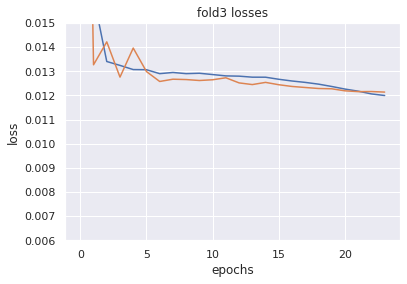

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65307, train_metric: 0.65300
valid_loss: 0.30387, valid_metric: 0.30334
-----EPOCH2-----
train_loss: 0.06699, train_metric: 0.06521
valid_loss: 0.02278, valid_metric: 0.02032
-----EPOCH3-----
train_loss: 0.02116, train_metric: 0.01844
valid_loss: 0.02056, valid_metric: 0.01769
-----EPOCH4-----
train_loss: 0.01999, train_metric: 0.01701
valid_loss: 0.02044, valid_metric: 0.01740
-----EPOCH5-----
train_loss: 0.02232, train_metric: 0.01918
valid_loss: 0.02052, valid_metric: 0.01723
-----EPOCH6-----
train_loss: 0.01973, train_metric: 0.01654
valid_loss: 0.02049, valid_metric: 0.01723
-----EPOCH7-----
train_loss: 0.01967, train_metric: 0.01645
valid_loss: 0.02059, valid_metric: 0.01727
-----EPOCH8-----
train_loss: 0.01952, train_metric: 0.01629
valid_loss: 0.02046, valid_metric: 0.01719
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01655
valid_loss: 0.02052, valid_metric: 0.01721
-----EPOCH10-----
train_loss: 0.01953, train_metric: 0.01

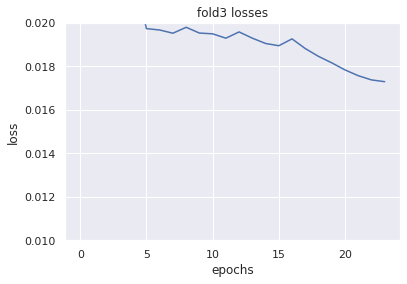

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50710, train_metric: 0.50667
valid_loss: 0.02537, valid_metric: 0.02323
-----EPOCH2-----
train_loss: 0.01629, train_metric: 0.01343
valid_loss: 0.01389, valid_metric: 0.01080
-----EPOCH3-----
train_loss: 0.01407, train_metric: 0.01080
valid_loss: 0.01396, valid_metric: 0.01020
-----EPOCH4-----
train_loss: 0.01309, train_metric: 0.00965
valid_loss: 0.01284, valid_metric: 0.00951
-----EPOCH5-----
train_loss: 0.01286, train_metric: 0.00953
valid_loss: 0.01281, valid_metric: 0.00951
-----EPOCH6-----
train_loss: 0.01284, train_metric: 0.00955
valid_loss: 0.01273, valid_metric: 0.00947
-----EPOCH7-----
train_loss: 0.01284, train_metric: 0.00957
valid_loss: 0.01269, valid_metric: 0.00940
-----EPOCH8-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01277, valid_metric: 0.00951
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00958
valid_loss: 0.01277, valid_metric: 0.00953
-----EPOCH10-----
train_loss: 0

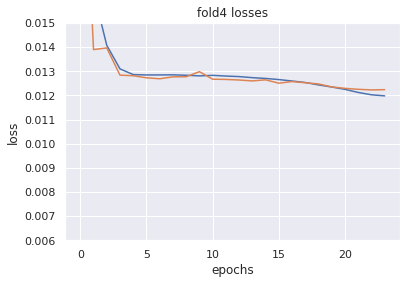

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65749, train_metric: 0.65742
valid_loss: 0.30816, valid_metric: 0.30764
-----EPOCH2-----
train_loss: 0.06725, train_metric: 0.06546
valid_loss: 0.02284, valid_metric: 0.02037
-----EPOCH3-----
train_loss: 0.02110, train_metric: 0.01839
valid_loss: 0.02066, valid_metric: 0.01778
-----EPOCH4-----
train_loss: 0.01992, train_metric: 0.01694
valid_loss: 0.02048, valid_metric: 0.01744
-----EPOCH5-----
train_loss: 0.02274, train_metric: 0.01960
valid_loss: 0.02073, valid_metric: 0.01746
-----EPOCH6-----
train_loss: 0.01976, train_metric: 0.01655
valid_loss: 0.02062, valid_metric: 0.01741
-----EPOCH7-----
train_loss: 0.01955, train_metric: 0.01633
valid_loss: 0.02050, valid_metric: 0.01726
-----EPOCH8-----
train_loss: 0.01944, train_metric: 0.01619
valid_loss: 0.02054, valid_metric: 0.01726
-----EPOCH9-----
train_loss: 0.01975, train_metric: 0.01650
valid_loss: 0.02054, valid_metric: 0.01732
-----EPOCH10-----
train_loss: 0.01939, train_metric: 0.01

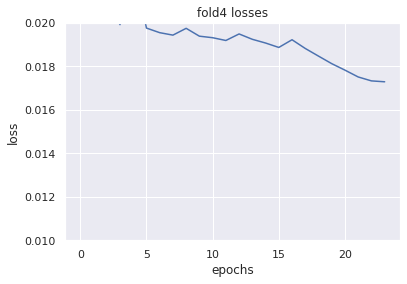

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50763, train_metric: 0.50720
valid_loss: 0.02481, valid_metric: 0.02262
-----EPOCH2-----
train_loss: 0.01599, train_metric: 0.01314
valid_loss: 0.01553, valid_metric: 0.01267
-----EPOCH3-----
train_loss: 0.01346, train_metric: 0.01016
valid_loss: 0.01317, valid_metric: 0.00989
-----EPOCH4-----
train_loss: 0.01310, train_metric: 0.00978
valid_loss: 0.01418, valid_metric: 0.01048
-----EPOCH5-----
train_loss: 0.01287, train_metric: 0.00953
valid_loss: 0.01454, valid_metric: 0.01126
-----EPOCH6-----
train_loss: 0.01349, train_metric: 0.01013
valid_loss: 0.01308, valid_metric: 0.00974
-----EPOCH7-----
train_loss: 0.01293, train_metric: 0.00964
valid_loss: 0.01309, valid_metric: 0.00983
-----EPOCH8-----
train_loss: 0.01303, train_metric: 0.00973
valid_loss: 0.01299, valid_metric: 0.00972
-----EPOCH9-----
train_loss: 0.01287, train_metric: 0.00960
valid_loss: 0.01314, valid_metric: 0.00993
-----EPOCH10-----
train_loss: 0

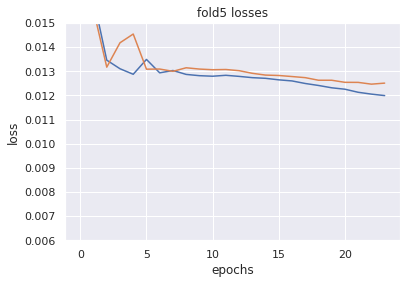

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65293, train_metric: 0.65286
valid_loss: 0.30972, valid_metric: 0.30921
-----EPOCH2-----
train_loss: 0.06733, train_metric: 0.06555
valid_loss: 0.02315, valid_metric: 0.02070
-----EPOCH3-----
train_loss: 0.02126, train_metric: 0.01854
valid_loss: 0.02078, valid_metric: 0.01793
-----EPOCH4-----
train_loss: 0.02014, train_metric: 0.01715
valid_loss: 0.02054, valid_metric: 0.01752
-----EPOCH5-----
train_loss: 0.02296, train_metric: 0.01976
valid_loss: 0.02078, valid_metric: 0.01741
-----EPOCH6-----
train_loss: 0.01983, train_metric: 0.01660
valid_loss: 0.02065, valid_metric: 0.01746
-----EPOCH7-----
train_loss: 0.01973, train_metric: 0.01649
valid_loss: 0.02051, valid_metric: 0.01727
-----EPOCH8-----
train_loss: 0.01962, train_metric: 0.01638
valid_loss: 0.02058, valid_metric: 0.01730
-----EPOCH9-----
train_loss: 0.01989, train_metric: 0.01665
valid_loss: 0.02066, valid_metric: 0.01736
-----EPOCH10-----
train_loss: 0.01965, train_metric: 0.01

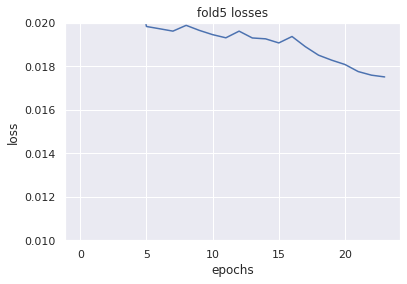

 
SEED : 1

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50828, train_metric: 0.50785
valid_loss: 0.02817, valid_metric: 0.02583
-----EPOCH2-----
train_loss: 0.01566, train_metric: 0.01283
valid_loss: 0.01408, valid_metric: 0.01105
-----EPOCH3-----
train_loss: 0.01322, train_metric: 0.01001
valid_loss: 0.01332, valid_metric: 0.01011
-----EPOCH4-----
train_loss: 0.01292, train_metric: 0.00963
valid_loss: 0.01323, valid_metric: 0.00996
-----EPOCH5-----
train_loss: 0.01289, train_metric: 0.00959
valid_loss: 0.01344, valid_metric: 0.01014
-----EPOCH6-----
train_loss: 0.01281, train_metric: 0.00949
valid_loss: 0.01351, valid_metric: 0.01024
-----EPOCH7-----
train_loss: 0.01276, train_metric: 0.00947
valid_loss: 0.01352, valid_metric: 0.01024
-----EPOCH8-----
train_loss: 0.01276, train_metric: 0.00950
valid_loss: 0.01305, valid_metric: 0.00981
-----EPOCH9-----
train_loss: 0.01272, train_metric: 0.00947
valid_loss: 0.01312, valid_metric: 0.00992
-----EPOCH10-----
t

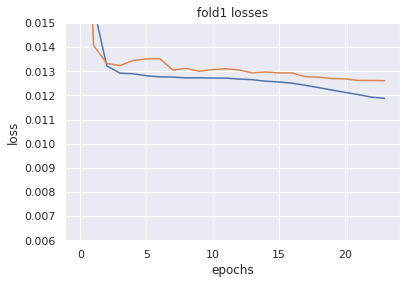

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65186, train_metric: 0.65179
valid_loss: 0.31117, valid_metric: 0.31066
-----EPOCH2-----
train_loss: 0.06774, train_metric: 0.06596
valid_loss: 0.02311, valid_metric: 0.02065
-----EPOCH3-----
train_loss: 0.02102, train_metric: 0.01830
valid_loss: 0.02090, valid_metric: 0.01804
-----EPOCH4-----
train_loss: 0.01990, train_metric: 0.01692
valid_loss: 0.02069, valid_metric: 0.01766
-----EPOCH5-----
train_loss: 0.02368, train_metric: 0.02050
valid_loss: 0.02065, valid_metric: 0.01736
-----EPOCH6-----
train_loss: 0.01962, train_metric: 0.01640
valid_loss: 0.02066, valid_metric: 0.01735
-----EPOCH7-----
train_loss: 0.01942, train_metric: 0.01619
valid_loss: 0.02055, valid_metric: 0.01734
-----EPOCH8-----
train_loss: 0.01932, train_metric: 0.01607
valid_loss: 0.02054, valid_metric: 0.01728
-----EPOCH9-----
train_loss: 0.01963, train_metric: 0.01637
valid_loss: 0.02065, valid_metric: 0.01736
-----EPOCH10-----
train_loss: 0.01936, train_metric: 0.01

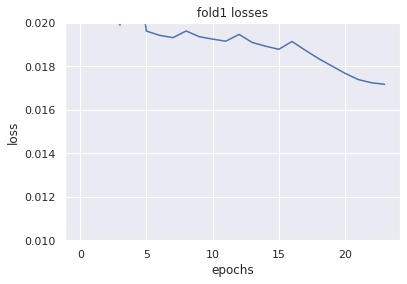

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50902, train_metric: 0.50859
valid_loss: 0.02873, valid_metric: 0.02640
-----EPOCH2-----
train_loss: 0.01592, train_metric: 0.01306
valid_loss: 0.01342, valid_metric: 0.01033
-----EPOCH3-----
train_loss: 0.01359, train_metric: 0.01038
valid_loss: 0.01318, valid_metric: 0.00981
-----EPOCH4-----
train_loss: 0.01335, train_metric: 0.00995
valid_loss: 0.01279, valid_metric: 0.00949
-----EPOCH5-----
train_loss: 0.01293, train_metric: 0.00963
valid_loss: 0.01268, valid_metric: 0.00936
-----EPOCH6-----
train_loss: 0.01301, train_metric: 0.00971
valid_loss: 0.01269, valid_metric: 0.00940
-----EPOCH7-----
train_loss: 0.01288, train_metric: 0.00961
valid_loss: 0.01267, valid_metric: 0.00938
-----EPOCH8-----
train_loss: 0.01285, train_metric: 0.00960
valid_loss: 0.01274, valid_metric: 0.00951
-----EPOCH9-----
train_loss: 0.01285, train_metric: 0.00960
valid_loss: 0.01267, valid_metric: 0.00938
-----EPOCH10-----
train_loss: 0

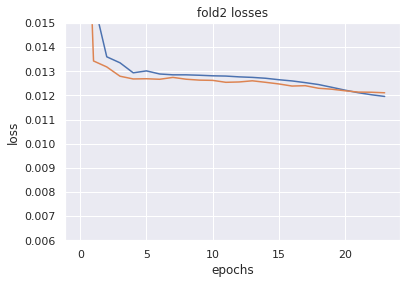

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65305, train_metric: 0.65298
valid_loss: 0.30385, valid_metric: 0.30332
-----EPOCH2-----
train_loss: 0.06719, train_metric: 0.06541
valid_loss: 0.02282, valid_metric: 0.02036
-----EPOCH3-----
train_loss: 0.02104, train_metric: 0.01833
valid_loss: 0.02065, valid_metric: 0.01779
-----EPOCH4-----
train_loss: 0.01985, train_metric: 0.01687
valid_loss: 0.02043, valid_metric: 0.01740
-----EPOCH5-----
train_loss: 0.02205, train_metric: 0.01889
valid_loss: 0.02054, valid_metric: 0.01733
-----EPOCH6-----
train_loss: 0.01971, train_metric: 0.01649
valid_loss: 0.02055, valid_metric: 0.01730
-----EPOCH7-----
train_loss: 0.01943, train_metric: 0.01619
valid_loss: 0.02044, valid_metric: 0.01719
-----EPOCH8-----
train_loss: 0.01930, train_metric: 0.01606
valid_loss: 0.02046, valid_metric: 0.01717
-----EPOCH9-----
train_loss: 0.01954, train_metric: 0.01629
valid_loss: 0.02067, valid_metric: 0.01745
-----EPOCH10-----
train_loss: 0.01932, train_metric: 0.01

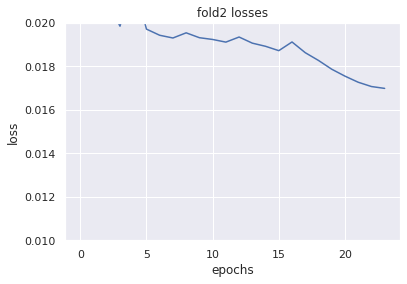

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51020, train_metric: 0.50977
valid_loss: 0.02719, valid_metric: 0.02499
-----EPOCH2-----
train_loss: 0.01566, train_metric: 0.01284
valid_loss: 0.01358, valid_metric: 0.01045
-----EPOCH3-----
train_loss: 0.01333, train_metric: 0.01011
valid_loss: 0.01341, valid_metric: 0.01019
-----EPOCH4-----
train_loss: 0.01302, train_metric: 0.00971
valid_loss: 0.01303, valid_metric: 0.00974
-----EPOCH5-----
train_loss: 0.01274, train_metric: 0.00943
valid_loss: 0.01312, valid_metric: 0.00987
-----EPOCH6-----
train_loss: 0.01275, train_metric: 0.00946
valid_loss: 0.01313, valid_metric: 0.00989
-----EPOCH7-----
train_loss: 0.01285, train_metric: 0.00957
valid_loss: 0.01301, valid_metric: 0.00975
-----EPOCH8-----
train_loss: 0.01281, train_metric: 0.00954
valid_loss: 0.01303, valid_metric: 0.00975
-----EPOCH9-----
train_loss: 0.01272, train_metric: 0.00946
valid_loss: 0.01303, valid_metric: 0.00975
-----EPOCH10-----
train_loss: 0

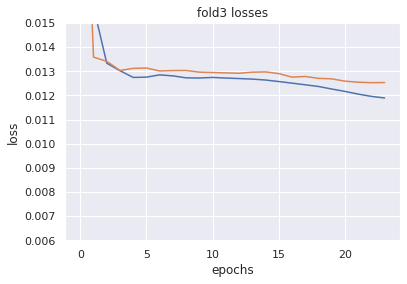

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65221, train_metric: 0.65214
valid_loss: 0.30937, valid_metric: 0.30885
-----EPOCH2-----
train_loss: 0.06817, train_metric: 0.06640
valid_loss: 0.02325, valid_metric: 0.02080
-----EPOCH3-----
train_loss: 0.02106, train_metric: 0.01836
valid_loss: 0.02086, valid_metric: 0.01800
-----EPOCH4-----
train_loss: 0.01990, train_metric: 0.01692
valid_loss: 0.02071, valid_metric: 0.01769
-----EPOCH5-----
train_loss: 0.02103, train_metric: 0.01788
valid_loss: 0.02073, valid_metric: 0.01757
-----EPOCH6-----
train_loss: 0.01960, train_metric: 0.01640
valid_loss: 0.02075, valid_metric: 0.01754
-----EPOCH7-----
train_loss: 0.01944, train_metric: 0.01621
valid_loss: 0.02077, valid_metric: 0.01751
-----EPOCH8-----
train_loss: 0.01931, train_metric: 0.01607
valid_loss: 0.02089, valid_metric: 0.01755
-----EPOCH9-----
train_loss: 0.01971, train_metric: 0.01647
valid_loss: 0.02077, valid_metric: 0.01750
-----EPOCH10-----
train_loss: 0.01938, train_metric: 0.01

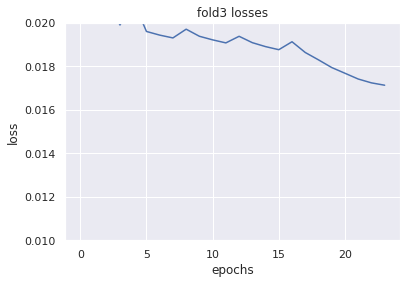

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50871, train_metric: 0.50828
valid_loss: 0.02419, valid_metric: 0.02209
-----EPOCH2-----
train_loss: 0.01587, train_metric: 0.01304
valid_loss: 0.01338, valid_metric: 0.01028
-----EPOCH3-----
train_loss: 0.01359, train_metric: 0.01037
valid_loss: 0.01310, valid_metric: 0.00960
-----EPOCH4-----
train_loss: 0.01303, train_metric: 0.00967
valid_loss: 0.01283, valid_metric: 0.00956
-----EPOCH5-----
train_loss: 0.01288, train_metric: 0.00957
valid_loss: 0.01268, valid_metric: 0.00940
-----EPOCH6-----
train_loss: 0.01282, train_metric: 0.00954
valid_loss: 0.01271, valid_metric: 0.00945
-----EPOCH7-----
train_loss: 0.01285, train_metric: 0.00958
valid_loss: 0.01271, valid_metric: 0.00949
-----EPOCH8-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01271, valid_metric: 0.00950
-----EPOCH9-----
train_loss: 0.01282, train_metric: 0.00957
valid_loss: 0.01273, valid_metric: 0.00947
-----EPOCH10-----
train_loss: 0

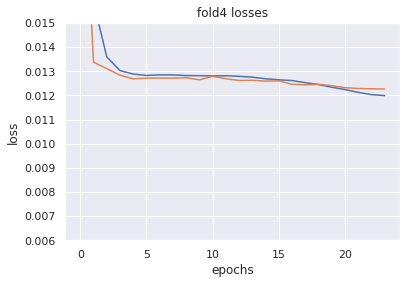

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.64958, train_metric: 0.64951
valid_loss: 0.30533, valid_metric: 0.30480
-----EPOCH2-----
train_loss: 0.06740, train_metric: 0.06562
valid_loss: 0.02299, valid_metric: 0.02053
-----EPOCH3-----
train_loss: 0.02108, train_metric: 0.01837
valid_loss: 0.02099, valid_metric: 0.01812
-----EPOCH4-----
train_loss: 0.02002, train_metric: 0.01704
valid_loss: 0.02070, valid_metric: 0.01768
-----EPOCH5-----
train_loss: 0.02160, train_metric: 0.01847
valid_loss: 0.02079, valid_metric: 0.01755
-----EPOCH6-----
train_loss: 0.01977, train_metric: 0.01657
valid_loss: 0.02074, valid_metric: 0.01756
-----EPOCH7-----
train_loss: 0.01963, train_metric: 0.01642
valid_loss: 0.02075, valid_metric: 0.01749
-----EPOCH8-----
train_loss: 0.01950, train_metric: 0.01627
valid_loss: 0.02076, valid_metric: 0.01756
-----EPOCH9-----
train_loss: 0.01968, train_metric: 0.01645
valid_loss: 0.02098, valid_metric: 0.01759
-----EPOCH10-----
train_loss: 0.01949, train_metric: 0.01

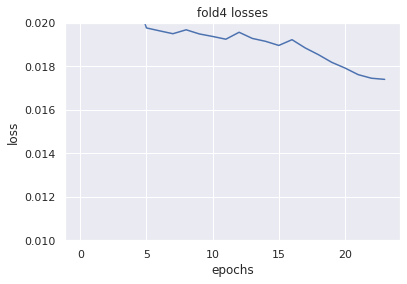

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50931, train_metric: 0.50888
valid_loss: 0.02678, valid_metric: 0.02456
-----EPOCH2-----
train_loss: 0.01588, train_metric: 0.01305
valid_loss: 0.01365, valid_metric: 0.01057
-----EPOCH3-----
train_loss: 0.01398, train_metric: 0.01074
valid_loss: 0.01480, valid_metric: 0.01124
-----EPOCH4-----
train_loss: 0.01322, train_metric: 0.00981
valid_loss: 0.01291, valid_metric: 0.00962
-----EPOCH5-----
train_loss: 0.01285, train_metric: 0.00954
valid_loss: 0.01348, valid_metric: 0.01007
-----EPOCH6-----
train_loss: 0.01290, train_metric: 0.00960
valid_loss: 0.01330, valid_metric: 0.01003
-----EPOCH7-----
train_loss: 0.01294, train_metric: 0.00966
valid_loss: 0.01291, valid_metric: 0.00962
-----EPOCH8-----
train_loss: 0.01282, train_metric: 0.00956
valid_loss: 0.01302, valid_metric: 0.00973
-----EPOCH9-----
train_loss: 0.01285, train_metric: 0.00960
valid_loss: 0.01295, valid_metric: 0.00969
-----EPOCH10-----
train_loss: 0

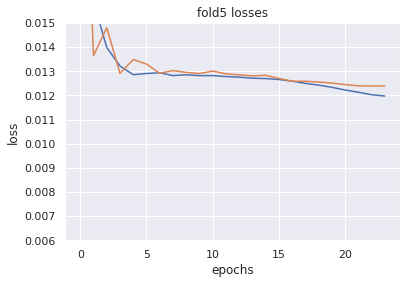

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65377, train_metric: 0.65370
valid_loss: 0.30947, valid_metric: 0.30895
-----EPOCH2-----
train_loss: 0.06758, train_metric: 0.06580
valid_loss: 0.02283, valid_metric: 0.02037
-----EPOCH3-----
train_loss: 0.02122, train_metric: 0.01851
valid_loss: 0.02058, valid_metric: 0.01769
-----EPOCH4-----
train_loss: 0.02012, train_metric: 0.01715
valid_loss: 0.02037, valid_metric: 0.01733
-----EPOCH5-----
train_loss: 0.02211, train_metric: 0.01893
valid_loss: 0.02033, valid_metric: 0.01710
-----EPOCH6-----
train_loss: 0.01986, train_metric: 0.01664
valid_loss: 0.02030, valid_metric: 0.01696
-----EPOCH7-----
train_loss: 0.01963, train_metric: 0.01640
valid_loss: 0.02038, valid_metric: 0.01706
-----EPOCH8-----
train_loss: 0.01957, train_metric: 0.01633
valid_loss: 0.02033, valid_metric: 0.01701
-----EPOCH9-----
train_loss: 0.01974, train_metric: 0.01650
valid_loss: 0.02050, valid_metric: 0.01724
-----EPOCH10-----
train_loss: 0.01956, train_metric: 0.01

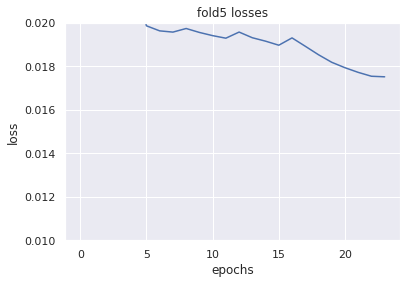

 
SEED : 2

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51126, train_metric: 0.51084
valid_loss: 0.02799, valid_metric: 0.02585
-----EPOCH2-----
train_loss: 0.01612, train_metric: 0.01328
valid_loss: 0.01354, valid_metric: 0.01041
-----EPOCH3-----
train_loss: 0.01351, train_metric: 0.01025
valid_loss: 0.01316, valid_metric: 0.00990
-----EPOCH4-----
train_loss: 0.01303, train_metric: 0.00971
valid_loss: 0.01301, valid_metric: 0.00971
-----EPOCH5-----
train_loss: 0.01283, train_metric: 0.00952
valid_loss: 0.01296, valid_metric: 0.00966
-----EPOCH6-----
train_loss: 0.01353, train_metric: 0.01012
valid_loss: 0.01307, valid_metric: 0.00969
-----EPOCH7-----
train_loss: 0.01291, train_metric: 0.00960
valid_loss: 0.01290, valid_metric: 0.00963
-----EPOCH8-----
train_loss: 0.01284, train_metric: 0.00958
valid_loss: 0.01285, valid_metric: 0.00962
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00958
valid_loss: 0.01287, valid_metric: 0.00963
-----EPOCH10-----
t

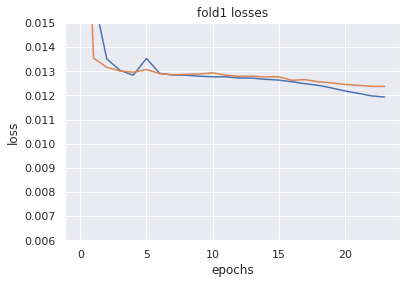

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65452, train_metric: 0.65445
valid_loss: 0.31060, valid_metric: 0.31009
-----EPOCH2-----
train_loss: 0.06748, train_metric: 0.06570
valid_loss: 0.02285, valid_metric: 0.02040
-----EPOCH3-----
train_loss: 0.02101, train_metric: 0.01829
valid_loss: 0.02058, valid_metric: 0.01769
-----EPOCH4-----
train_loss: 0.01986, train_metric: 0.01688
valid_loss: 0.02047, valid_metric: 0.01743
-----EPOCH5-----
train_loss: 0.02279, train_metric: 0.01965
valid_loss: 0.02050, valid_metric: 0.01723
-----EPOCH6-----
train_loss: 0.01959, train_metric: 0.01637
valid_loss: 0.02059, valid_metric: 0.01727
-----EPOCH7-----
train_loss: 0.01942, train_metric: 0.01617
valid_loss: 0.02041, valid_metric: 0.01713
-----EPOCH8-----
train_loss: 0.01937, train_metric: 0.01612
valid_loss: 0.02046, valid_metric: 0.01717
-----EPOCH9-----
train_loss: 0.01954, train_metric: 0.01628
valid_loss: 0.02076, valid_metric: 0.01748
-----EPOCH10-----
train_loss: 0.01932, train_metric: 0.01

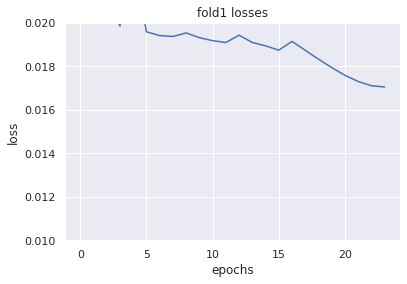

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51027, train_metric: 0.50984
valid_loss: 0.02735, valid_metric: 0.02524
-----EPOCH2-----
train_loss: 0.01576, train_metric: 0.01293
valid_loss: 0.01374, valid_metric: 0.01061
-----EPOCH3-----
train_loss: 0.01333, train_metric: 0.01010
valid_loss: 0.01329, valid_metric: 0.01010
-----EPOCH4-----
train_loss: 0.01288, train_metric: 0.00959
valid_loss: 0.01325, valid_metric: 0.00997
-----EPOCH5-----
train_loss: 0.01274, train_metric: 0.00943
valid_loss: 0.01307, valid_metric: 0.00981
-----EPOCH6-----
train_loss: 0.01293, train_metric: 0.00962
valid_loss: 0.01310, valid_metric: 0.00983
-----EPOCH7-----
train_loss: 0.01273, train_metric: 0.00945
valid_loss: 0.01324, valid_metric: 0.00998
-----EPOCH8-----
train_loss: 0.01277, train_metric: 0.00951
valid_loss: 0.01312, valid_metric: 0.00983
-----EPOCH9-----
train_loss: 0.01273, train_metric: 0.00947
valid_loss: 0.01313, valid_metric: 0.00986
-----EPOCH10-----
train_loss: 0

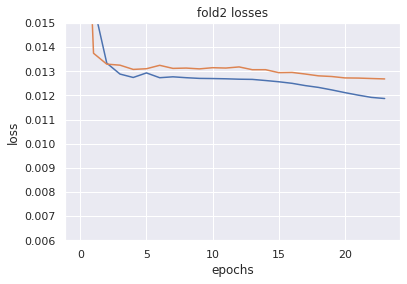

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65168, train_metric: 0.65160
valid_loss: 0.30856, valid_metric: 0.30804
-----EPOCH2-----
train_loss: 0.06652, train_metric: 0.06473
valid_loss: 0.02312, valid_metric: 0.02067
-----EPOCH3-----
train_loss: 0.02092, train_metric: 0.01820
valid_loss: 0.02111, valid_metric: 0.01823
-----EPOCH4-----
train_loss: 0.01981, train_metric: 0.01683
valid_loss: 0.02086, valid_metric: 0.01783
-----EPOCH5-----
train_loss: 0.02255, train_metric: 0.01931
valid_loss: 0.02107, valid_metric: 0.01773
-----EPOCH6-----
train_loss: 0.01961, train_metric: 0.01636
valid_loss: 0.02099, valid_metric: 0.01766
-----EPOCH7-----
train_loss: 0.01936, train_metric: 0.01611
valid_loss: 0.02102, valid_metric: 0.01772
-----EPOCH8-----
train_loss: 0.01937, train_metric: 0.01611
valid_loss: 0.02096, valid_metric: 0.01770
-----EPOCH9-----
train_loss: 0.01955, train_metric: 0.01630
valid_loss: 0.02117, valid_metric: 0.01780
-----EPOCH10-----
train_loss: 0.01938, train_metric: 0.01

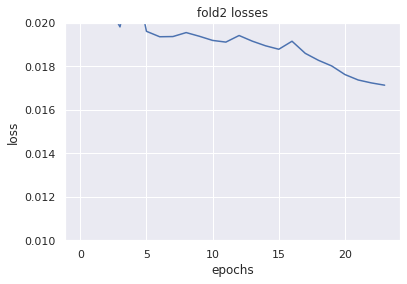

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50761, train_metric: 0.50718
valid_loss: 0.06770, valid_metric: 0.06577
-----EPOCH2-----
train_loss: 0.01590, train_metric: 0.01308
valid_loss: 0.01462, valid_metric: 0.01139
-----EPOCH3-----
train_loss: 0.01370, train_metric: 0.01038
valid_loss: 0.01371, valid_metric: 0.01044
-----EPOCH4-----
train_loss: 0.01304, train_metric: 0.00973
valid_loss: 0.01463, valid_metric: 0.01135
-----EPOCH5-----
train_loss: 0.01384, train_metric: 0.01055
valid_loss: 0.01964, valid_metric: 0.01382
-----EPOCH6-----
train_loss: 0.01336, train_metric: 0.00987
valid_loss: 0.01330, valid_metric: 0.01001
-----EPOCH7-----
train_loss: 0.01299, train_metric: 0.00968
valid_loss: 0.01348, valid_metric: 0.01022
-----EPOCH8-----
train_loss: 0.01294, train_metric: 0.00968
valid_loss: 0.01319, valid_metric: 0.00995
-----EPOCH9-----
train_loss: 0.01291, train_metric: 0.00967
valid_loss: 0.01297, valid_metric: 0.00972
-----EPOCH10-----
train_loss: 0

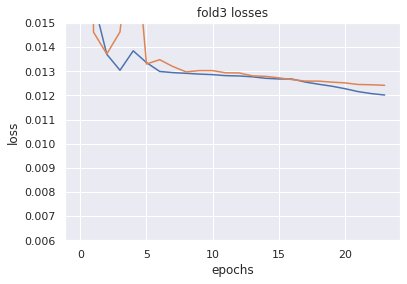

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65277, train_metric: 0.65270
valid_loss: 0.30270, valid_metric: 0.30216
-----EPOCH2-----
train_loss: 0.06639, train_metric: 0.06461
valid_loss: 0.02337, valid_metric: 0.02091
-----EPOCH3-----
train_loss: 0.02121, train_metric: 0.01850
valid_loss: 0.02116, valid_metric: 0.01829
-----EPOCH4-----
train_loss: 0.02004, train_metric: 0.01707
valid_loss: 0.02100, valid_metric: 0.01797
-----EPOCH5-----
train_loss: 0.02423, train_metric: 0.02110
valid_loss: 0.02100, valid_metric: 0.01781
-----EPOCH6-----
train_loss: 0.01981, train_metric: 0.01661
valid_loss: 0.02097, valid_metric: 0.01777
-----EPOCH7-----
train_loss: 0.01968, train_metric: 0.01645
valid_loss: 0.02101, valid_metric: 0.01772
-----EPOCH8-----
train_loss: 0.01963, train_metric: 0.01640
valid_loss: 0.02094, valid_metric: 0.01767
-----EPOCH9-----
train_loss: 0.01983, train_metric: 0.01660
valid_loss: 0.02093, valid_metric: 0.01767
-----EPOCH10-----
train_loss: 0.01963, train_metric: 0.01

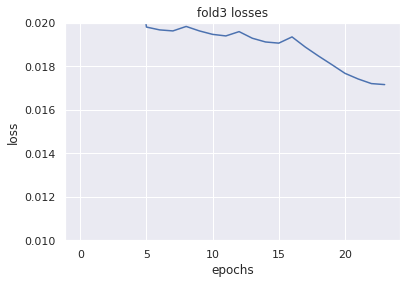

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50849, train_metric: 0.50806
valid_loss: 0.02671, valid_metric: 0.02454
-----EPOCH2-----
train_loss: 0.01605, train_metric: 0.01320
valid_loss: 0.01345, valid_metric: 0.01032
-----EPOCH3-----
train_loss: 0.01357, train_metric: 0.01030
valid_loss: 0.01306, valid_metric: 0.00976
-----EPOCH4-----
train_loss: 0.01303, train_metric: 0.00972
valid_loss: 0.01281, valid_metric: 0.00955
-----EPOCH5-----
train_loss: 0.01296, train_metric: 0.00965
valid_loss: 0.01282, valid_metric: 0.00951
-----EPOCH6-----
train_loss: 0.01286, train_metric: 0.00956
valid_loss: 0.01314, valid_metric: 0.00990
-----EPOCH7-----
train_loss: 0.01284, train_metric: 0.00957
valid_loss: 0.01310, valid_metric: 0.00985
-----EPOCH8-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01349, valid_metric: 0.01028
-----EPOCH9-----
train_loss: 0.01284, train_metric: 0.00959
valid_loss: 0.01329, valid_metric: 0.01009
-----EPOCH10-----
train_loss: 0

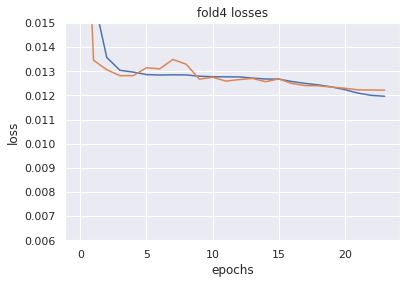

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65144, train_metric: 0.65137
valid_loss: 0.30670, valid_metric: 0.30618
-----EPOCH2-----
train_loss: 0.06712, train_metric: 0.06533
valid_loss: 0.02275, valid_metric: 0.02029
-----EPOCH3-----
train_loss: 0.02118, train_metric: 0.01846
valid_loss: 0.02047, valid_metric: 0.01760
-----EPOCH4-----
train_loss: 0.01996, train_metric: 0.01698
valid_loss: 0.02031, valid_metric: 0.01729
-----EPOCH5-----
train_loss: 0.02177, train_metric: 0.01858
valid_loss: 0.02021, valid_metric: 0.01693
-----EPOCH6-----
train_loss: 0.01967, train_metric: 0.01645
valid_loss: 0.02025, valid_metric: 0.01692
-----EPOCH7-----
train_loss: 0.01950, train_metric: 0.01627
valid_loss: 0.02015, valid_metric: 0.01695
-----EPOCH8-----
train_loss: 0.01941, train_metric: 0.01617
valid_loss: 0.02022, valid_metric: 0.01696
-----EPOCH9-----
train_loss: 0.01965, train_metric: 0.01642
valid_loss: 0.02031, valid_metric: 0.01710
-----EPOCH10-----
train_loss: 0.01941, train_metric: 0.01

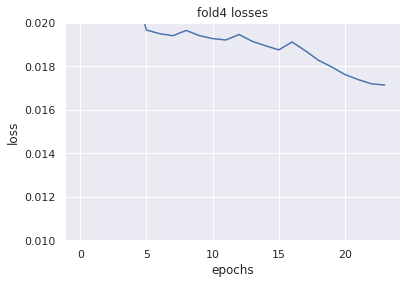

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50963, train_metric: 0.50920
valid_loss: 0.03458, valid_metric: 0.03223
-----EPOCH2-----
train_loss: 0.01611, train_metric: 0.01325
valid_loss: 0.01339, valid_metric: 0.01025
-----EPOCH3-----
train_loss: 0.01361, train_metric: 0.01034
valid_loss: 0.01286, valid_metric: 0.00960
-----EPOCH4-----
train_loss: 0.01308, train_metric: 0.00976
valid_loss: 0.01319, valid_metric: 0.00987
-----EPOCH5-----
train_loss: 0.01293, train_metric: 0.00961
valid_loss: 0.01263, valid_metric: 0.00928
-----EPOCH6-----
train_loss: 0.01290, train_metric: 0.00959
valid_loss: 0.01269, valid_metric: 0.00941
-----EPOCH7-----
train_loss: 0.01289, train_metric: 0.00961
valid_loss: 0.01281, valid_metric: 0.00956
-----EPOCH8-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01269, valid_metric: 0.00940
-----EPOCH9-----
train_loss: 0.01282, train_metric: 0.00956
valid_loss: 0.01259, valid_metric: 0.00931
-----EPOCH10-----
train_loss: 0

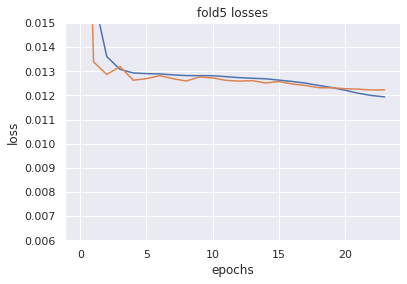

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65470, train_metric: 0.65463
valid_loss: 0.31125, valid_metric: 0.31074
-----EPOCH2-----
train_loss: 0.06764, train_metric: 0.06586
valid_loss: 0.02306, valid_metric: 0.02060
-----EPOCH3-----
train_loss: 0.02106, train_metric: 0.01835
valid_loss: 0.02075, valid_metric: 0.01787
-----EPOCH4-----
train_loss: 0.01986, train_metric: 0.01688
valid_loss: 0.02061, valid_metric: 0.01759
-----EPOCH5-----
train_loss: 0.02283, train_metric: 0.01966
valid_loss: 0.02070, valid_metric: 0.01738
-----EPOCH6-----
train_loss: 0.01958, train_metric: 0.01636
valid_loss: 0.02057, valid_metric: 0.01728
-----EPOCH7-----
train_loss: 0.01941, train_metric: 0.01617
valid_loss: 0.02060, valid_metric: 0.01736
-----EPOCH8-----
train_loss: 0.01929, train_metric: 0.01604
valid_loss: 0.02053, valid_metric: 0.01730
-----EPOCH9-----
train_loss: 0.01957, train_metric: 0.01632
valid_loss: 0.02060, valid_metric: 0.01738
-----EPOCH10-----
train_loss: 0.01930, train_metric: 0.01

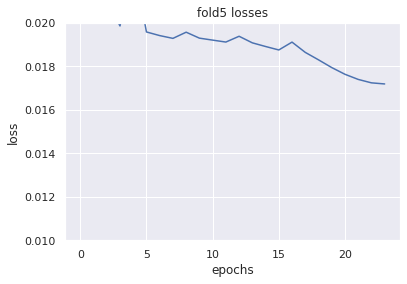

 
SEED : 3

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50845, train_metric: 0.50802
valid_loss: 0.02585, valid_metric: 0.02354
-----EPOCH2-----
train_loss: 0.01620, train_metric: 0.01334
valid_loss: 0.01342, valid_metric: 0.01014
-----EPOCH3-----
train_loss: 0.01340, train_metric: 0.01013
valid_loss: 0.01634, valid_metric: 0.01310
-----EPOCH4-----
train_loss: 0.01314, train_metric: 0.00984
valid_loss: 0.01324, valid_metric: 0.00990
-----EPOCH5-----
train_loss: 0.01288, train_metric: 0.00955
valid_loss: 0.01380, valid_metric: 0.01054
-----EPOCH6-----
train_loss: 0.01291, train_metric: 0.00962
valid_loss: 0.01329, valid_metric: 0.00997
-----EPOCH7-----
train_loss: 0.01292, train_metric: 0.00963
valid_loss: 0.01279, valid_metric: 0.00943
-----EPOCH8-----
train_loss: 0.01279, train_metric: 0.00951
valid_loss: 0.01285, valid_metric: 0.00958
-----EPOCH9-----
train_loss: 0.01282, train_metric: 0.00957
valid_loss: 0.01268, valid_metric: 0.00945
-----EPOCH10-----
t

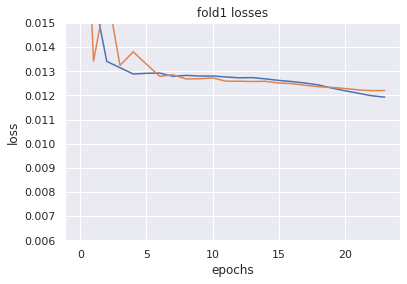

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65325, train_metric: 0.65317
valid_loss: 0.30634, valid_metric: 0.30582
-----EPOCH2-----
train_loss: 0.06705, train_metric: 0.06527
valid_loss: 0.02283, valid_metric: 0.02039
-----EPOCH3-----
train_loss: 0.02111, train_metric: 0.01841
valid_loss: 0.02055, valid_metric: 0.01769
-----EPOCH4-----
train_loss: 0.01986, train_metric: 0.01689
valid_loss: 0.02029, valid_metric: 0.01727
-----EPOCH5-----
train_loss: 0.02401, train_metric: 0.02089
valid_loss: 0.02019, valid_metric: 0.01690
-----EPOCH6-----
train_loss: 0.01963, train_metric: 0.01643
valid_loss: 0.02014, valid_metric: 0.01688
-----EPOCH7-----
train_loss: 0.01940, train_metric: 0.01618
valid_loss: 0.02024, valid_metric: 0.01699
-----EPOCH8-----
train_loss: 0.01938, train_metric: 0.01614
valid_loss: 0.02021, valid_metric: 0.01693
-----EPOCH9-----
train_loss: 0.01968, train_metric: 0.01644
valid_loss: 0.02028, valid_metric: 0.01704
-----EPOCH10-----
train_loss: 0.01938, train_metric: 0.01

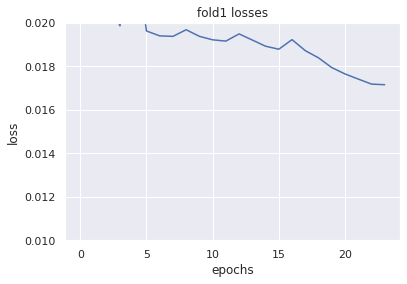

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50766, train_metric: 0.50723
valid_loss: 0.03757, valid_metric: 0.03564
-----EPOCH2-----
train_loss: 0.01671, train_metric: 0.01385
valid_loss: 0.01387, valid_metric: 0.01057
-----EPOCH3-----
train_loss: 0.01338, train_metric: 0.01003
valid_loss: 0.01336, valid_metric: 0.01011
-----EPOCH4-----
train_loss: 0.01299, train_metric: 0.00965
valid_loss: 0.01476, valid_metric: 0.01147
-----EPOCH5-----
train_loss: 0.01283, train_metric: 0.00952
valid_loss: 0.01384, valid_metric: 0.01068
-----EPOCH6-----
train_loss: 0.01288, train_metric: 0.00956
valid_loss: 0.01335, valid_metric: 0.01016
-----EPOCH7-----
train_loss: 0.01282, train_metric: 0.00953
valid_loss: 0.01310, valid_metric: 0.00985
-----EPOCH8-----
train_loss: 0.01274, train_metric: 0.00946
valid_loss: 0.01453, valid_metric: 0.01125
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00957
valid_loss: 0.01306, valid_metric: 0.00978
-----EPOCH10-----
train_loss: 0

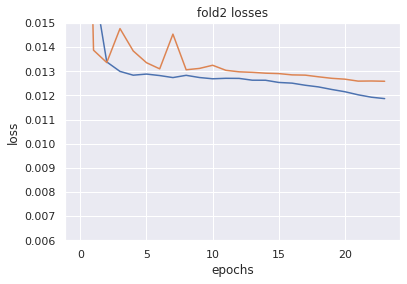

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65496, train_metric: 0.65489
valid_loss: 0.30711, valid_metric: 0.30659
-----EPOCH2-----
train_loss: 0.06736, train_metric: 0.06559
valid_loss: 0.02305, valid_metric: 0.02061
-----EPOCH3-----
train_loss: 0.02108, train_metric: 0.01837
valid_loss: 0.02089, valid_metric: 0.01802
-----EPOCH4-----
train_loss: 0.01984, train_metric: 0.01687
valid_loss: 0.02080, valid_metric: 0.01776
-----EPOCH5-----
train_loss: 0.02203, train_metric: 0.01887
valid_loss: 0.02082, valid_metric: 0.01750
-----EPOCH6-----
train_loss: 0.01953, train_metric: 0.01631
valid_loss: 0.02072, valid_metric: 0.01743
-----EPOCH7-----
train_loss: 0.01935, train_metric: 0.01612
valid_loss: 0.02072, valid_metric: 0.01746
-----EPOCH8-----
train_loss: 0.01925, train_metric: 0.01600
valid_loss: 0.02072, valid_metric: 0.01747
-----EPOCH9-----
train_loss: 0.01950, train_metric: 0.01625
valid_loss: 0.02075, valid_metric: 0.01747
-----EPOCH10-----
train_loss: 0.01932, train_metric: 0.01

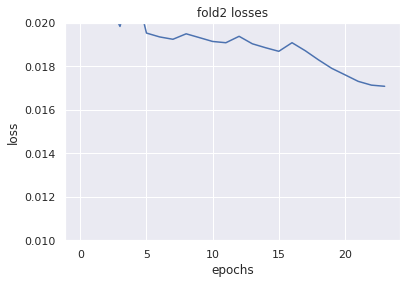

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50978, train_metric: 0.50935
valid_loss: 0.02422, valid_metric: 0.02203
-----EPOCH2-----
train_loss: 0.01566, train_metric: 0.01284
valid_loss: 0.01545, valid_metric: 0.01235
-----EPOCH3-----
train_loss: 0.01340, train_metric: 0.01018
valid_loss: 0.01303, valid_metric: 0.00980
-----EPOCH4-----
train_loss: 0.01291, train_metric: 0.00963
valid_loss: 0.01297, valid_metric: 0.00962
-----EPOCH5-----
train_loss: 0.01278, train_metric: 0.00948
valid_loss: 0.01332, valid_metric: 0.01000
-----EPOCH6-----
train_loss: 0.01301, train_metric: 0.00967
valid_loss: 0.01292, valid_metric: 0.00960
-----EPOCH7-----
train_loss: 0.01277, train_metric: 0.00948
valid_loss: 0.01280, valid_metric: 0.00952
-----EPOCH8-----
train_loss: 0.01276, train_metric: 0.00950
valid_loss: 0.01291, valid_metric: 0.00969
-----EPOCH9-----
train_loss: 0.01278, train_metric: 0.00953
valid_loss: 0.01295, valid_metric: 0.00962
-----EPOCH10-----
train_loss: 0

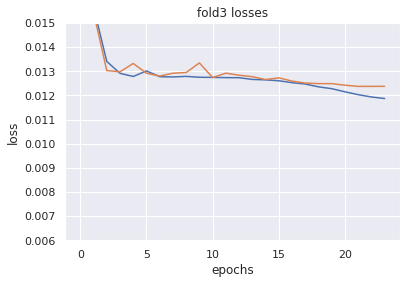

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65422, train_metric: 0.65415
valid_loss: 0.30882, valid_metric: 0.30830
-----EPOCH2-----
train_loss: 0.06799, train_metric: 0.06621
valid_loss: 0.02298, valid_metric: 0.02052
-----EPOCH3-----
train_loss: 0.02105, train_metric: 0.01833
valid_loss: 0.02076, valid_metric: 0.01788
-----EPOCH4-----
train_loss: 0.01984, train_metric: 0.01686
valid_loss: 0.02068, valid_metric: 0.01764
-----EPOCH5-----
train_loss: 0.02116, train_metric: 0.01799
valid_loss: 0.02085, valid_metric: 0.01763
-----EPOCH6-----
train_loss: 0.01957, train_metric: 0.01636
valid_loss: 0.02070, valid_metric: 0.01750
-----EPOCH7-----
train_loss: 0.01941, train_metric: 0.01618
valid_loss: 0.02064, valid_metric: 0.01736
-----EPOCH8-----
train_loss: 0.01933, train_metric: 0.01609
valid_loss: 0.02064, valid_metric: 0.01737
-----EPOCH9-----
train_loss: 0.01957, train_metric: 0.01632
valid_loss: 0.02072, valid_metric: 0.01749
-----EPOCH10-----
train_loss: 0.01929, train_metric: 0.01

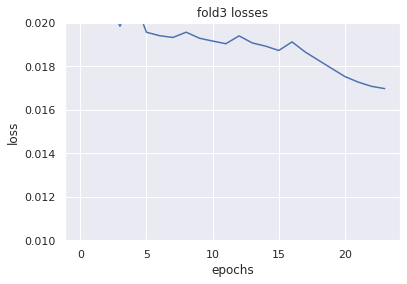

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51034, train_metric: 0.50991
valid_loss: 0.02405, valid_metric: 0.02191
-----EPOCH2-----
train_loss: 0.01618, train_metric: 0.01334
valid_loss: 0.01377, valid_metric: 0.01062
-----EPOCH3-----
train_loss: 0.01350, train_metric: 0.01022
valid_loss: 0.01290, valid_metric: 0.00967
-----EPOCH4-----
train_loss: 0.01458, train_metric: 0.01111
valid_loss: 0.01317, valid_metric: 0.00977
-----EPOCH5-----
train_loss: 0.01298, train_metric: 0.00957
valid_loss: 0.01289, valid_metric: 0.00963
-----EPOCH6-----
train_loss: 0.01286, train_metric: 0.00955
valid_loss: 0.01278, valid_metric: 0.00952
-----EPOCH7-----
train_loss: 0.01284, train_metric: 0.00957
valid_loss: 0.01279, valid_metric: 0.00957
-----EPOCH8-----
train_loss: 0.01284, train_metric: 0.00959
valid_loss: 0.01278, valid_metric: 0.00958
-----EPOCH9-----
train_loss: 0.01284, train_metric: 0.00959
valid_loss: 0.01279, valid_metric: 0.00955
-----EPOCH10-----
train_loss: 0

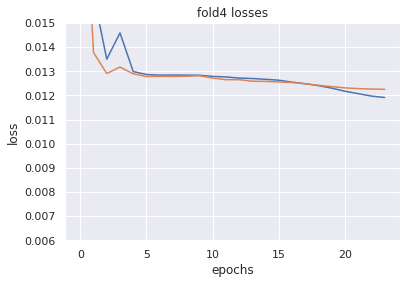

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65997, train_metric: 0.65991
valid_loss: 0.31801, valid_metric: 0.31750
-----EPOCH2-----
train_loss: 0.06924, train_metric: 0.06747
valid_loss: 0.02332, valid_metric: 0.02088
-----EPOCH3-----
train_loss: 0.02102, train_metric: 0.01832
valid_loss: 0.02107, valid_metric: 0.01821
-----EPOCH4-----
train_loss: 0.01978, train_metric: 0.01680
valid_loss: 0.02076, valid_metric: 0.01773
-----EPOCH5-----
train_loss: 0.02321, train_metric: 0.01996
valid_loss: 0.02096, valid_metric: 0.01756
-----EPOCH6-----
train_loss: 0.01945, train_metric: 0.01618
valid_loss: 0.02088, valid_metric: 0.01754
-----EPOCH7-----
train_loss: 0.01932, train_metric: 0.01606
valid_loss: 0.02082, valid_metric: 0.01753
-----EPOCH8-----
train_loss: 0.01917, train_metric: 0.01590
valid_loss: 0.02087, valid_metric: 0.01762
-----EPOCH9-----
train_loss: 0.01939, train_metric: 0.01612
valid_loss: 0.02090, valid_metric: 0.01761
-----EPOCH10-----
train_loss: 0.01922, train_metric: 0.01

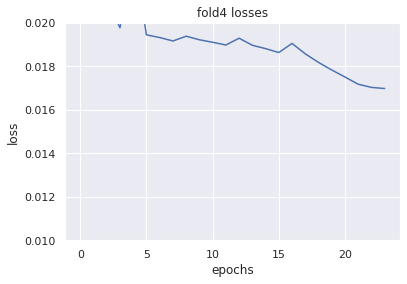

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51076, train_metric: 0.51033
valid_loss: 0.02553, valid_metric: 0.02323
-----EPOCH2-----
train_loss: 0.01639, train_metric: 0.01353
valid_loss: 0.01375, valid_metric: 0.01063
-----EPOCH3-----
train_loss: 0.01345, train_metric: 0.01020
valid_loss: 0.01332, valid_metric: 0.01009
-----EPOCH4-----
train_loss: 0.01294, train_metric: 0.00965
valid_loss: 0.01320, valid_metric: 0.00997
-----EPOCH5-----
train_loss: 0.01279, train_metric: 0.00947
valid_loss: 0.01296, valid_metric: 0.00968
-----EPOCH6-----
train_loss: 0.01280, train_metric: 0.00950
valid_loss: 0.01297, valid_metric: 0.00970
-----EPOCH7-----
train_loss: 0.01279, train_metric: 0.00949
valid_loss: 0.01292, valid_metric: 0.00967
-----EPOCH8-----
train_loss: 0.01275, train_metric: 0.00949
valid_loss: 0.01307, valid_metric: 0.00984
-----EPOCH9-----
train_loss: 0.01276, train_metric: 0.00950
valid_loss: 0.01292, valid_metric: 0.00966
-----EPOCH10-----
train_loss: 0

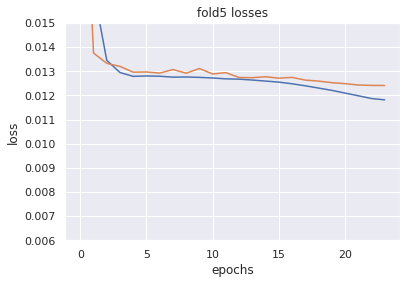

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65616, train_metric: 0.65609
valid_loss: 0.31088, valid_metric: 0.31036
-----EPOCH2-----
train_loss: 0.06819, train_metric: 0.06642
valid_loss: 0.02300, valid_metric: 0.02056
-----EPOCH3-----
train_loss: 0.02103, train_metric: 0.01832
valid_loss: 0.02070, valid_metric: 0.01784
-----EPOCH4-----
train_loss: 0.01972, train_metric: 0.01675
valid_loss: 0.02059, valid_metric: 0.01757
-----EPOCH5-----
train_loss: 0.02400, train_metric: 0.02086
valid_loss: 0.02042, valid_metric: 0.01722
-----EPOCH6-----
train_loss: 0.01941, train_metric: 0.01619
valid_loss: 0.02039, valid_metric: 0.01714
-----EPOCH7-----
train_loss: 0.01921, train_metric: 0.01597
valid_loss: 0.02039, valid_metric: 0.01712
-----EPOCH8-----
train_loss: 0.01908, train_metric: 0.01582
valid_loss: 0.02034, valid_metric: 0.01710
-----EPOCH9-----
train_loss: 0.01944, train_metric: 0.01618
valid_loss: 0.02035, valid_metric: 0.01708
-----EPOCH10-----
train_loss: 0.01915, train_metric: 0.01

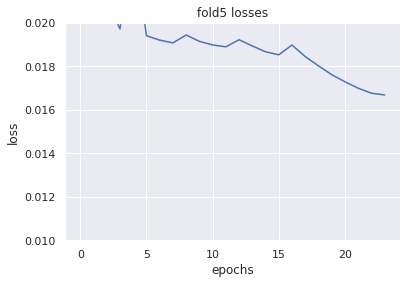

 
SEED : 4

==========FOLD1==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50924, train_metric: 0.50881
valid_loss: 0.02516, valid_metric: 0.02307
-----EPOCH2-----
train_loss: 0.01605, train_metric: 0.01321
valid_loss: 0.01351, valid_metric: 0.01035
-----EPOCH3-----
train_loss: 0.01331, train_metric: 0.01007
valid_loss: 0.01305, valid_metric: 0.00982
-----EPOCH4-----
train_loss: 0.01286, train_metric: 0.00958
valid_loss: 0.01291, valid_metric: 0.00964
-----EPOCH5-----
train_loss: 0.01290, train_metric: 0.00960
valid_loss: 0.01448, valid_metric: 0.01107
-----EPOCH6-----
train_loss: 0.01287, train_metric: 0.00958
valid_loss: 0.01284, valid_metric: 0.00954
-----EPOCH7-----
train_loss: 0.01284, train_metric: 0.00956
valid_loss: 0.01284, valid_metric: 0.00959
-----EPOCH8-----
train_loss: 0.01281, train_metric: 0.00955
valid_loss: 0.01289, valid_metric: 0.00959
-----EPOCH9-----
train_loss: 0.01281, train_metric: 0.00955
valid_loss: 0.01279, valid_metric: 0.00943
-----EPOCH10-----
t

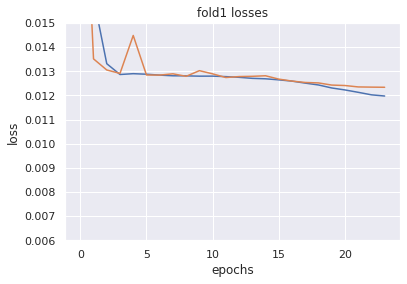

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65021, train_metric: 0.65014
valid_loss: 0.30464, valid_metric: 0.30411
-----EPOCH2-----
train_loss: 0.06757, train_metric: 0.06579
valid_loss: 0.02278, valid_metric: 0.02031
-----EPOCH3-----
train_loss: 0.02109, train_metric: 0.01837
valid_loss: 0.02067, valid_metric: 0.01780
-----EPOCH4-----
train_loss: 0.01995, train_metric: 0.01698
valid_loss: 0.02048, valid_metric: 0.01745
-----EPOCH5-----
train_loss: 0.02181, train_metric: 0.01865
valid_loss: 0.02055, valid_metric: 0.01718
-----EPOCH6-----
train_loss: 0.01971, train_metric: 0.01650
valid_loss: 0.02033, valid_metric: 0.01707
-----EPOCH7-----
train_loss: 0.01960, train_metric: 0.01637
valid_loss: 0.02039, valid_metric: 0.01713
-----EPOCH8-----
train_loss: 0.01949, train_metric: 0.01626
valid_loss: 0.02045, valid_metric: 0.01719
-----EPOCH9-----
train_loss: 0.01977, train_metric: 0.01653
valid_loss: 0.02044, valid_metric: 0.01714
-----EPOCH10-----
train_loss: 0.01942, train_metric: 0.01

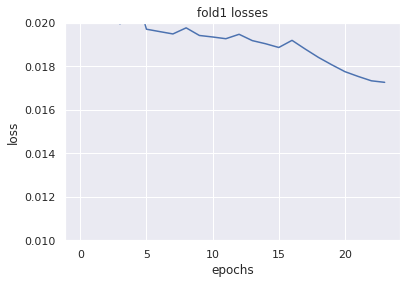

==========FOLD2==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50992, train_metric: 0.50950
valid_loss: 0.03094, valid_metric: 0.02882
-----EPOCH2-----
train_loss: 0.01589, train_metric: 0.01307
valid_loss: 0.01386, valid_metric: 0.01077
-----EPOCH3-----
train_loss: 0.01350, train_metric: 0.01029
valid_loss: 0.01369, valid_metric: 0.01047
-----EPOCH4-----
train_loss: 0.01320, train_metric: 0.00991
valid_loss: 0.30724, valid_metric: 0.30430
-----EPOCH5-----
train_loss: 0.01422, train_metric: 0.01077
valid_loss: 0.01326, valid_metric: 0.00983
-----EPOCH6-----
train_loss: 0.01326, train_metric: 0.00996
valid_loss: 0.01390, valid_metric: 0.01063
-----EPOCH7-----
train_loss: 0.01305, train_metric: 0.00980
valid_loss: 0.01287, valid_metric: 0.00959
-----EPOCH8-----
train_loss: 0.01296, train_metric: 0.00972
valid_loss: 0.01313, valid_metric: 0.00990
-----EPOCH9-----
train_loss: 0.01294, train_metric: 0.00970
valid_loss: 0.01296, valid_metric: 0.00972
-----EPOCH10-----
train_loss: 0

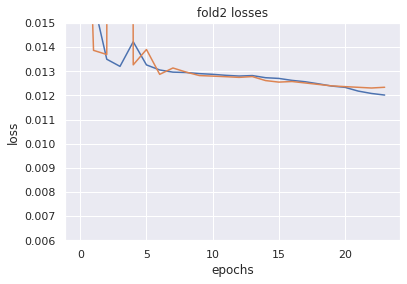

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65138, train_metric: 0.65131
valid_loss: 0.30059, valid_metric: 0.30006
-----EPOCH2-----
train_loss: 0.06659, train_metric: 0.06481
valid_loss: 0.02295, valid_metric: 0.02050
-----EPOCH3-----
train_loss: 0.02123, train_metric: 0.01852
valid_loss: 0.02084, valid_metric: 0.01798
-----EPOCH4-----
train_loss: 0.02006, train_metric: 0.01709
valid_loss: 0.02053, valid_metric: 0.01752
-----EPOCH5-----
train_loss: 0.02588, train_metric: 0.02281
valid_loss: 0.02055, valid_metric: 0.01720
-----EPOCH6-----
train_loss: 0.01980, train_metric: 0.01663
valid_loss: 0.02051, valid_metric: 0.01725
-----EPOCH7-----
train_loss: 0.01960, train_metric: 0.01639
valid_loss: 0.02052, valid_metric: 0.01725
-----EPOCH8-----
train_loss: 0.01954, train_metric: 0.01631
valid_loss: 0.02053, valid_metric: 0.01725
-----EPOCH9-----
train_loss: 0.01982, train_metric: 0.01657
valid_loss: 0.02055, valid_metric: 0.01728
-----EPOCH10-----
train_loss: 0.01958, train_metric: 0.01

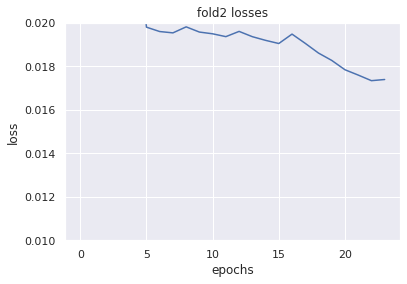

==========FOLD3==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50821, train_metric: 0.50778
valid_loss: 0.02773, valid_metric: 0.02559
-----EPOCH2-----
train_loss: 0.01614, train_metric: 0.01330
valid_loss: 0.01489, valid_metric: 0.01171
-----EPOCH3-----
train_loss: 0.01349, train_metric: 0.01025
valid_loss: 0.01333, valid_metric: 0.01008
-----EPOCH4-----
train_loss: 0.01363, train_metric: 0.01023
valid_loss: 0.01322, valid_metric: 0.00980
-----EPOCH5-----
train_loss: 0.01284, train_metric: 0.00946
valid_loss: 0.01303, valid_metric: 0.00972
-----EPOCH6-----
train_loss: 0.01282, train_metric: 0.00952
valid_loss: 0.01329, valid_metric: 0.01004
-----EPOCH7-----
train_loss: 0.01284, train_metric: 0.00957
valid_loss: 0.01309, valid_metric: 0.00980
-----EPOCH8-----
train_loss: 0.01280, train_metric: 0.00954
valid_loss: 0.01313, valid_metric: 0.00986
-----EPOCH9-----
train_loss: 0.01276, train_metric: 0.00951
valid_loss: 0.01327, valid_metric: 0.01001
-----EPOCH10-----
train_loss: 0

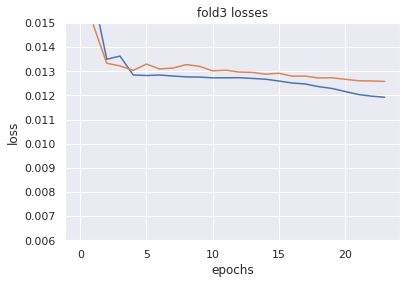

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65350, train_metric: 0.65343
valid_loss: 0.30402, valid_metric: 0.30349
-----EPOCH2-----
train_loss: 0.06732, train_metric: 0.06554
valid_loss: 0.02308, valid_metric: 0.02062
-----EPOCH3-----
train_loss: 0.02112, train_metric: 0.01841
valid_loss: 0.02089, valid_metric: 0.01802
-----EPOCH4-----
train_loss: 0.01995, train_metric: 0.01697
valid_loss: 0.02070, valid_metric: 0.01767
-----EPOCH5-----
train_loss: 0.02315, train_metric: 0.01997
valid_loss: 0.02090, valid_metric: 0.01769
-----EPOCH6-----
train_loss: 0.01969, train_metric: 0.01646
valid_loss: 0.02075, valid_metric: 0.01750
-----EPOCH7-----
train_loss: 0.01947, train_metric: 0.01624
valid_loss: 0.02073, valid_metric: 0.01748
-----EPOCH8-----
train_loss: 0.01939, train_metric: 0.01615
valid_loss: 0.02080, valid_metric: 0.01756
-----EPOCH9-----
train_loss: 0.01976, train_metric: 0.01651
valid_loss: 0.02069, valid_metric: 0.01737
-----EPOCH10-----
train_loss: 0.01949, train_metric: 0.01

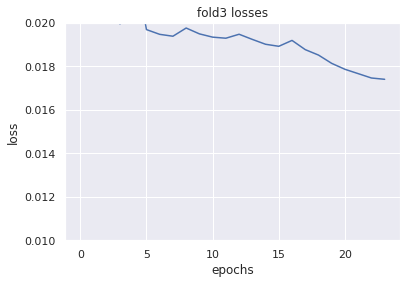

==========FOLD4==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.51095, train_metric: 0.51053
valid_loss: 0.02351, valid_metric: 0.02133
-----EPOCH2-----
train_loss: 0.01663, train_metric: 0.01376
valid_loss: 0.01348, valid_metric: 0.01035
-----EPOCH3-----
train_loss: 0.01343, train_metric: 0.01018
valid_loss: 0.01294, valid_metric: 0.00971
-----EPOCH4-----
train_loss: 0.01423, train_metric: 0.01073
valid_loss: 0.01304, valid_metric: 0.00960
-----EPOCH5-----
train_loss: 0.01300, train_metric: 0.00963
valid_loss: 0.01292, valid_metric: 0.00962
-----EPOCH6-----
train_loss: 0.01287, train_metric: 0.00956
valid_loss: 0.01294, valid_metric: 0.00968
-----EPOCH7-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01280, valid_metric: 0.00951
-----EPOCH8-----
train_loss: 0.01285, train_metric: 0.00959
valid_loss: 0.01285, valid_metric: 0.00957
-----EPOCH9-----
train_loss: 0.01283, train_metric: 0.00958
valid_loss: 0.01274, valid_metric: 0.00947
-----EPOCH10-----
train_loss: 0

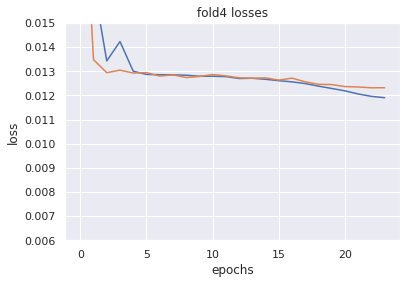

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65817, train_metric: 0.65810
valid_loss: 0.31257, valid_metric: 0.31206
-----EPOCH2-----
train_loss: 0.06831, train_metric: 0.06654
valid_loss: 0.02298, valid_metric: 0.02053
-----EPOCH3-----
train_loss: 0.02109, train_metric: 0.01838
valid_loss: 0.02065, valid_metric: 0.01778
-----EPOCH4-----
train_loss: 0.01985, train_metric: 0.01688
valid_loss: 0.02051, valid_metric: 0.01749
-----EPOCH5-----
train_loss: 0.02452, train_metric: 0.02136
valid_loss: 0.02061, valid_metric: 0.01734
-----EPOCH6-----
train_loss: 0.01958, train_metric: 0.01636
valid_loss: 0.02064, valid_metric: 0.01742
-----EPOCH7-----
train_loss: 0.01937, train_metric: 0.01612
valid_loss: 0.02051, valid_metric: 0.01726
-----EPOCH8-----
train_loss: 0.01928, train_metric: 0.01602
valid_loss: 0.02055, valid_metric: 0.01731
-----EPOCH9-----
train_loss: 0.01955, train_metric: 0.01629
valid_loss: 0.02054, valid_metric: 0.01725
-----EPOCH10-----
train_loss: 0.01927, train_metric: 0.01

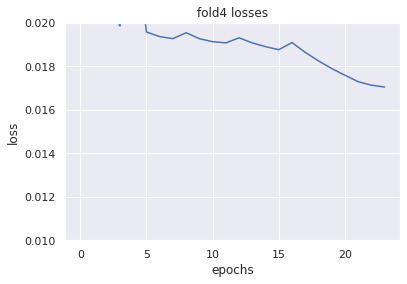

==========FOLD5==========
==ALL_TARGETS==
-----EPOCH1-----
train_loss: 0.50906, train_metric: 0.50863
valid_loss: 0.02559, valid_metric: 0.02324
-----EPOCH2-----
train_loss: 0.01564, train_metric: 0.01282
valid_loss: 0.01386, valid_metric: 0.01082
-----EPOCH3-----
train_loss: 0.01339, train_metric: 0.01016
valid_loss: 0.01325, valid_metric: 0.00999
-----EPOCH4-----
train_loss: 0.01299, train_metric: 0.00969
valid_loss: 0.01372, valid_metric: 0.01052
-----EPOCH5-----
train_loss: 0.01293, train_metric: 0.00961
valid_loss: 0.01310, valid_metric: 0.00975
-----EPOCH6-----
train_loss: 0.01292, train_metric: 0.00958
valid_loss: 0.01304, valid_metric: 0.00964
-----EPOCH7-----
train_loss: 0.01277, train_metric: 0.00948
valid_loss: 0.01296, valid_metric: 0.00974
-----EPOCH8-----
train_loss: 0.01280, train_metric: 0.00954
valid_loss: 0.01290, valid_metric: 0.00965
-----EPOCH9-----
train_loss: 0.01277, train_metric: 0.00951
valid_loss: 0.01316, valid_metric: 0.00986
-----EPOCH10-----
train_loss: 0

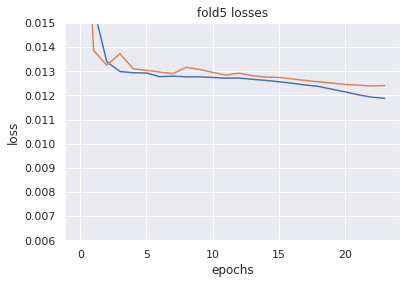

==SCORED_ONLY==
-----EPOCH1-----
train_loss: 0.65442, train_metric: 0.65435
valid_loss: 0.30762, valid_metric: 0.30710
-----EPOCH2-----
train_loss: 0.06707, train_metric: 0.06530
valid_loss: 0.02309, valid_metric: 0.02063
-----EPOCH3-----
train_loss: 0.02096, train_metric: 0.01825
valid_loss: 0.02092, valid_metric: 0.01804
-----EPOCH4-----
train_loss: 0.01978, train_metric: 0.01680
valid_loss: 0.02080, valid_metric: 0.01774
-----EPOCH5-----
train_loss: 0.02328, train_metric: 0.02007
valid_loss: 0.02099, valid_metric: 0.01779
-----EPOCH6-----
train_loss: 0.01948, train_metric: 0.01624
valid_loss: 0.02070, valid_metric: 0.01745
-----EPOCH7-----
train_loss: 0.01939, train_metric: 0.01614
valid_loss: 0.02076, valid_metric: 0.01751
-----EPOCH8-----
train_loss: 0.01924, train_metric: 0.01599
valid_loss: 0.02075, valid_metric: 0.01745
-----EPOCH9-----
train_loss: 0.01948, train_metric: 0.01622
valid_loss: 0.02104, valid_metric: 0.01772
-----EPOCH10-----
train_loss: 0.01917, train_metric: 0.01

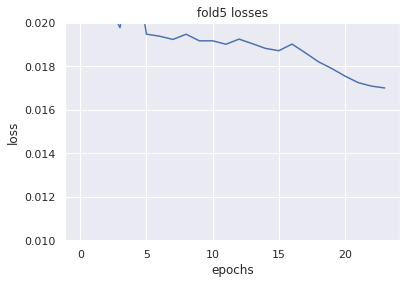

In [35]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3, 4]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

print(f'device used: {DEVICE}')

for seed in SEED:
    
    print(f' ')
    print(f'SEED : {seed}')
    print(f'')
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed, EPOCHS, LEARNING_RATE)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)
    
train[target_cols] = oof
test[target_cols] = predictions

In [36]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(
    train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

cv = 0
for i in range(len(target_cols)):
    cv_ = log_loss(y_true[:, i], y_pred[:, i])
    cv += cv_ / len(target_cols)
    
auc = 0
for i in range(len(target_cols)):
    auc_ = roc_auc_score(y_true[:, i], y_pred[:, i])
    auc += auc_ / len(target_cols)
    
print(f'CV log_loss: {cv:.6f}')
print(f'AUC: {auc:.6f}')

CV log_loss: 0.015582
AUC: 0.676437


In [37]:
file_path = 'oof_Simple_Deep.npy'
np.save(file_path, oof)

sub = sample_submission.drop(columns=target_cols).merge(
    test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [38]:
print(f'sample_submission.shape : {sample_submission.shape}')
print(f'sub.shape : {sub.shape}')

sample_submission.shape : (3982, 207)
sub.shape : (3982, 207)
